# Bank customer churn prediction

In this notebook we shall do the following things:

- Read the data. The data is downloaded from [this link.](https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset)

- Preprocess the data.

- Use Random Forest classification technique to model the bank customer churn.

- Save the model for future use.

## Import necessary libraries

In [1]:
# for loading and processing the dataset
import pandas as pd
import numpy as np

#for model building, training and testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier

# for saving the preprocessing data and model
import json
import joblib
import os

# for plotting
import matplotlib.pyplot as plt

## Read the data

In [2]:
data = pd.read_csv("../data/Bank_Customer_Churn_Prediction.csv")

data.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [4]:
data.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Data Pre-processing

We shall use following features:

 - credit_score
 - country
 - gender
 - age
 - tenure
 - balance
 - products_number
 - credit_card
 - active_member
 - estimated_salary
 
We shall use sklearn ColumnTransformer for this purpose.

In [5]:
numeric_features = ['credit_score', 'age', 'balance', 'estimated_salary','tenure', 'products_number']
categorical_features = ['country', 'gender', 'credit_card', 'active_member']

In [6]:
feature_list = numeric_features + categorical_features

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ]
)

## Building, training and Testing the model

In [8]:
X = data[feature_list]
y = data['churn']

### Splitting the data into train and test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, shuffle=True)

### Building a pipeline with preprocessor and classifier

In [10]:
# We are using the random forest classifier without finetuning the hyperparameters.

clf = RandomForestClassifier(n_estimators=250, max_depth=10, min_samples_split=20, min_samples_leaf=10)

In [11]:
model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", clf)]
)

### Fitting the model

In [12]:
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluating the model performance

In [13]:
model.score(X_test, y_test)

0.8525

In [14]:
model.score(X_train, y_train)

0.879125

### Determining threshold

We will determine the threshold that will maximize the f1-score

In [15]:
y_pred = model.predict_proba(X_test)[:,1]

In [16]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

In [17]:
f1score = (2 * precision * recall) / (precision + recall)

In [18]:
ix = np.argmax(f1score)
best_th = round(thresholds[ix],4)
best_f1_score = round(f1score[ix])

In [19]:
print(f'Best Threshold={thresholds[ix]:.4f}, F1-Score={f1score[ix]:.4f}')

Best Threshold=0.3173, F1-Score=0.6166


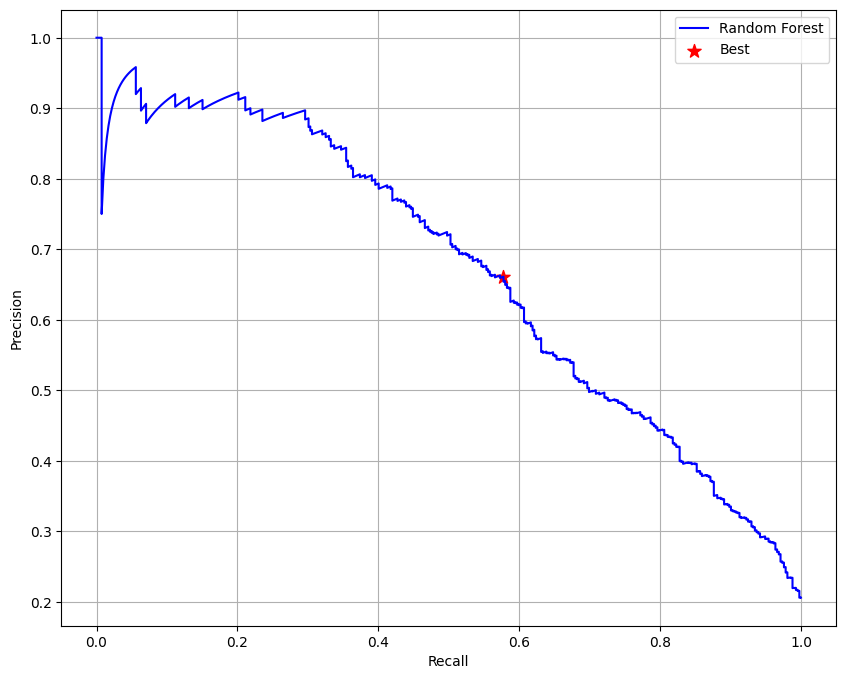

In [20]:
# plot the precision-recall curve for the model\
plt.figure(figsize=(10,8))
plt.plot(recall, precision, color='b', label='Random Forest')
plt.scatter(recall[ix], precision[ix], marker='*', s=100, color='red', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
# show the plot
plt.show()

## Retrain the model on entire dataset and save the model

In [21]:
final_clf = RandomForestClassifier(n_estimators=250, max_depth=10, min_samples_split=20, min_samples_leaf=10)

In [22]:
final_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", final_clf)]
)

In [23]:
final_model.fit(X, y)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Saving the model

In [24]:
# check if the model folder exist
if not os.path.exists("../models"):
    # If the folder doesn't exis, create it
    os.makedirs("../models")

filename = '../models/churn_prediction_model_rf.joblib'

joblib.dump(final_model, filename, compress=3)

['../models/churn_prediction_model_rf.joblib']

## Saving other necessary details

In [25]:
details_dict = dict()

In [26]:
details_dict['threshold'] = best_th
details_dict['feature_list'] = feature_list
details_dict['model_filename'] = "churn_prediction_model_rf.joblib"
details_dict['feature_range'] = {}

for x in feature_list:
    if x in numeric_features:
        details_dict['feature_range'][x] = {"min": int(round(np.min(data[x]))),
                                            "max": int(round(np.max(data[x])))}
    else:
        details_dict['feature_range'][x] = np.unique(data[x]).tolist()

In [27]:
# Putting config in the ../config.json file inside root folder

with open("../config.json", "w") as json_file:
    json.dump(details_dict, json_file, indent=4)
json_file.close()